In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
surajghuwalewala_ham1000_segmentation_and_classification_path = kagglehub.dataset_download('surajghuwalewala/ham1000-segmentation-and-classification')

print('Data source import complete.')


#  Using U-Net Architecture - Segmenting Skin Cancer Images

## 1. Importing required libraries

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import glob as gb
import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, Recall, MeanSquaredError

from tensorflow.keras import backend as K

sns.set_theme(style='darkgrid', palette='pastel')

## 2. Checking the dataset if there are enough masks corresponding to the images

In [3]:
# images and masks folder paths
image_dir = '/content/drive/MyDrive/Skin_Cancer_image_classification/images'
mask_dir = '/content/drive/MyDrive/Skin_Cancer_image_classification/masks'

# list of images and masks from the directory
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])

# generating lis of image names (without extension) & masks names (without 'segmentation' suffix & extension)
image_names = [os.path.splitext(f)[0] for f in image_files]
mask_names = [os.path.splitext(f)[0].replace('_segmentation', '') for f in mask_files]

# checking if all the images have corresponding masks or not
missing_masks = [img for img in image_names if img not in mask_names]

if len(missing_masks) == 0:
    print('All images have corresponding masks...')
else:
    print(f'No of images that dont have corresponding masks: {len(missing_images)}')

All images have corresponding masks...


## 3. Displaying the images and their corresponding masks

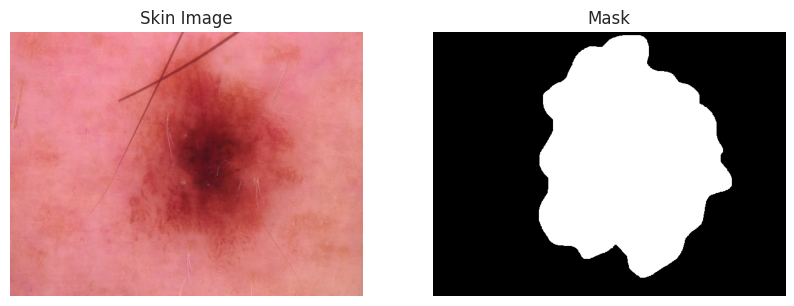

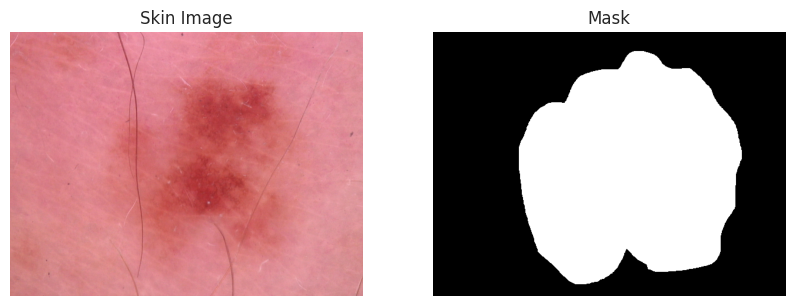

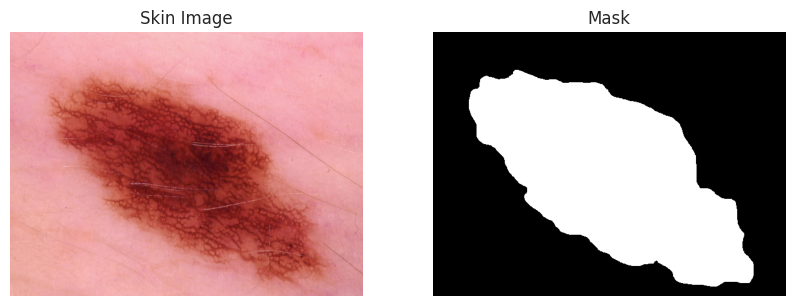

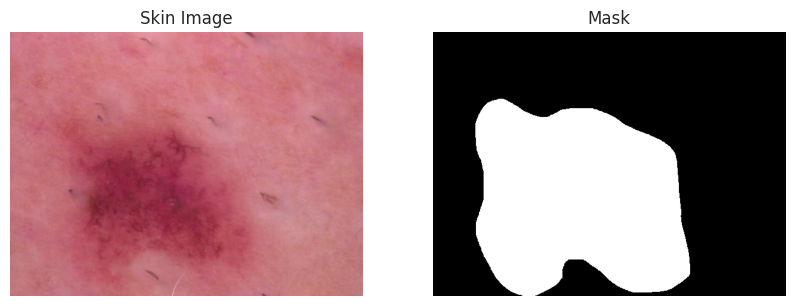

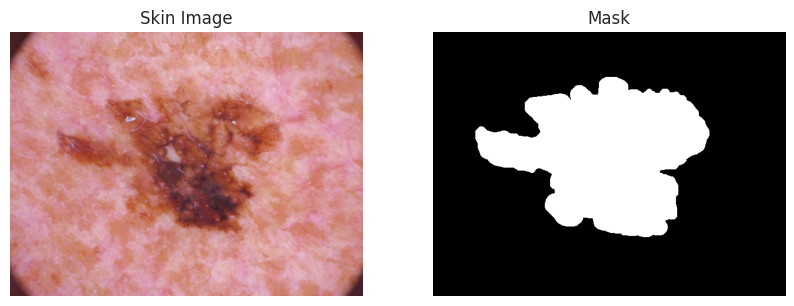

In [4]:
import matplotlib.pyplot as plt
from PIL import Image

# function to display image & mask
def display_function(image_path, mask_path):
    image = Image.open(image_path)
    mask = Image.open(mask_path)

    # side by side display
    fig, axis = plt.subplots(1, 2, figsize=(10, 5))
    axis[0].imshow(image)
    axis[0].set_title('Skin Image')
    axis[0].axis('off')

    axis[1].imshow(mask, cmap='gray')
    axis[1].set_title('Mask')
    axis[1].axis('off')

    plt.show()


# Displaying 5 images & masks
for i in range(5):
    image_path = os.path.join(image_dir, image_files[i])

    mask_name = os.path.splitext(image_files[i])[0] + '_segmentation.png'
    mask_path = os.path.join(mask_dir, mask_name)

    display_function(image_path, mask_path)

## 4. Displaying masked images

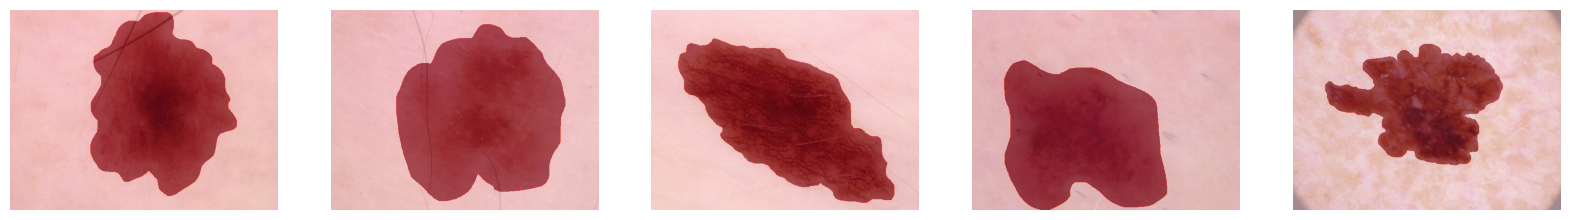

In [5]:
# function to display masked images
def display_masked_images(image_path, mask_path):
    image = Image.open(image_path)
    mask = Image.open(mask_path)

    # converting image & mask to numpy array
    image_np = np.array(image)
    mask_np = np.array(mask)

    return image_np, mask_np

# displaying 5 masked images
fig, axis = plt.subplots(1, 5, figsize=(20,5))

for i in range(5):
    image_path = os.path.join(image_dir, image_files[i])

    mask_name = os.path.splitext(image_files[i])[0] + '_segmentation.png'
    mask_path = os.path.join(mask_dir, mask_name)

    image_np, mask_np = display_masked_images(image_path, mask_path)

    # display masked images
    axis[i].imshow(image_np)
    axis[i].imshow(mask_np, cmap='Reds', alpha=0.5) # alpha - to make it semi transparent
    axis[i].axis('off')

plt.show()

## 5. Preparing data

In [6]:
# setting the default values
IMG_SIZE = 256
BATCH_SIZE = 32
BUFFER_SIZE = 1000

AUTOTUNE = tf.data.experimental.AUTOTUNE

IMG_DIR = '/content/drive/MyDrive/Skin_Cancer_image_classification/images'
MASK_DIR = '/content/drive/MyDrive/Skin_Cancer_image_classification/masks'

In [7]:
# function to get image path and masks
def image_mask_paths(image_dir, mask_dir):
    images_path = sorted(gb.glob(os.path.join(image_dir, '*.jpg')))
    masks_path = sorted(gb.glob(os.path.join(mask_dir, '*.png')))

    images_path = np.array(images_path)
    masks_path = np.array(masks_path)

    return images_path, masks_path

images_path, masks_path = image_mask_paths(IMG_DIR, MASK_DIR)

## 6. Dividing dataset into training & validation set

In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(images_path, masks_path, train_size=0.8, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=0.5, random_state=42)

print(f'Training Samples: {len(X_train)}')
print(f'Validation Samples: {len(X_val)}')
print(f'Testing Samples: {len(X_test)}')

Training Samples: 8012
Validation Samples: 1001
Testing Samples: 1002


In [9]:
# function to loading & preprocessing data

def mapping_function(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32)/255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
    mask = tf.cast(mask, tf.float32) / 255.0

    return img, mask

# creating training set
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_set = train_set.map(mapping_function, num_parallel_calls=AUTOTUNE)
train_set = train_set.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# creating validation set
validation_set = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation_set = validation_set.map(mapping_function, num_parallel_calls=AUTOTUNE)
validation_set = validation_set.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# creating testing set
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_set = test_set.map(mapping_function, num_parallel_calls=AUTOTUNE)
test_set = test_set.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [10]:
print(f'Length of Training Set: {len(train_set)}')
print(f'Length of Validation Set: {len(validation_set)}')
print(f'Length of Testing Set: {len(test_set)}')

Length of Training Set: 251
Length of Validation Set: 32
Length of Testing Set: 32


## 7. U-Net model implementation

In [11]:
def UNET():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    x = Conv2D(32, 3, strides=1, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    skip_connections = []

    # Encoder
    for filters in [64, 128, 256, 512]:
        x = Conv2D(filters, 3, strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = Conv2D(filters, 3, strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        skip_connections.append(x)
        x = MaxPooling2D(2, strides=2, padding="same")(x)

    # Bottleneck
    x = Conv2D(1024, 3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = Conv2D(1024, 3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Decoder
    for filters in [512, 256, 128, 64]:
        x = Conv2DTranspose(filters, 2, strides=2, padding="same")(x)
        skip_connection = skip_connections.pop()
        x = layers.add([x, skip_connection])

        x = Conv2D(filters, 3, strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = Conv2D(filters, 3, strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = layers.Activation("relu")(x)

    outputs = Conv2D(1, 1, strides=1, activation="sigmoid")(x)

    model = Model(inputs, outputs)
    return model

## 8. Loss Functions

In [12]:
# Dice Coefficient
def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    dice = (2 * intersection + smooth) / (union + smooth)
    return tf.reduce_mean(dice, axis=0)

# Dice Loss
def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

# IoU Metric
def iou(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3]) - intersection
    iou_score = (intersection + smooth) / (union + smooth)
    return tf.reduce_mean(iou_score, axis=0)

## 9. Model Compilation

In [13]:
model = UNET()
model.compile(
    optimizer=Adam(learning_rate=0.0002),
    loss=BinaryCrossentropy(),
    metrics=[
        'binary_accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        dice_coefficient,
        iou,
        MeanSquaredError(name='mse')
    ]
)

## 11. Model Summary

In [15]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         18,496 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256, 256, 64)   │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 256, 256, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 128, 128, 128)  │            512 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 27,939,585 (106.58 MB)

 Trainable params: 27,927,745 (106.54 MB)

 Non-trainable params: 11,840 (46.25 KB)

## 12. Model Training

In [ ]:
history = model.fit(
    train_set,
    epochs=10,
    validation_data=validation_set
)

Epoch 1/10


## 13. Plotting the results graphs

In [ ]:
# Function to plot training and validation metrics
def plot_training_metrics(history):
    """
    Plots training and validation metrics for loss, accuracy, IoU, precision, and recall.
    """
    epochs = range(1, len(history.history['loss']) + 1)

    plt.style.use('default')

    # Create a figure for all plots
    plt.figure(figsize=(18, 12))

    # Plot Loss
    plt.subplot(2, 3, 1)
    plt.plot(epochs, history.history['loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'r--', label='Validation Loss')
    plt.title('Loss - Binary Crossentropy Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()

    # Plot Accuracy
    plt.subplot(2, 3, 2)
    plt.plot(epochs, history.history['binary_accuracy'], 'g-', label='Training Accuracy')
    plt.plot(epochs, history.history['val_binary_accuracy'], 'r--', label='Validation Accuracy')
    plt.title('Binary Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()

    # Plot IoU
    plt.subplot(2, 3, 3)
    if 'iou' in history.history:
        plt.plot(epochs, history.history['iou'], 'm-', label='Training IoU')
        plt.plot(epochs, history.history['val_iou'], 'r--', label='Validation IoU')
        plt.title('IoU')
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.legend()
    else:
        plt.title('IoU Not Found in History')

    # Plot Precision
    plt.subplot(2, 3, 4)
    if 'precision' in history.history:
        plt.plot(epochs, history.history['precision'], 'b-', label='Training Precision')
        plt.plot(epochs, history.history['val_precision'], 'r--', label='Validation Precision')
        plt.title('Precision')
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.legend()
    else:
        plt.title('Precision Not Found in History')

    # Plot Recall
    plt.subplot(2, 3, 5)
    if 'recall' in history.history:
        plt.plot(epochs, history.history['recall'], 'g-', label='Training Recall')
        plt.plot(epochs, history.history['val_recall'], 'r--', label='Validation Recall')
        plt.title('Recall')
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.legend()
    else:
        plt.title('Recall Not Found in History')


    # Plot MSE
    plt.subplot(2, 3, 6)
    if 'mse' in history.history:
        plt.plot(epochs, history.history['recall'], 'm-', label='Training MSE')
        plt.plot(epochs, history.history['val_recall'], 'r--', label='Validation MSE')
        plt.title('MSE')
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.legend()
    else:
        plt.title('MSE Not Found in History')

    # Adjust layout for better display
    plt.tight_layout()
    plt.show()

# Example usage
plot_training_metrics(history)

## 14. Model Evaluation using testing dataset

In [ ]:
test_loss, test_accuracy, test_precision, test_recall, test_dice, test_iou, test_mse = model.evaluate(test_set)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test Dice Coefficient: {test_dice:.4f}")
print(f"Test IOU: {test_iou:.4f}")
print(f"Test Mean Squared Error: {test_mse:.4f}")

## 15. Displaying Testing Images, Ground Truth Masks & Predicted Masks

In [ ]:
def calculating_dice(y_true, y_pred, smooth=1):
    # converting tensors to numpy array (only for y_true)
    y_true_f = y_true.numpy().flatten()
    y_pred_f = y_pred.flatten()

    intersection = np.sum(y_true_f * y_pred_f)

    dice = (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

    return dice

In [ ]:
# taking the 1st 10 images for prediction
num_images = 10
test_images, test_masks = next(iter(test_set)) # getting batch images from the generator

# predicting the 1st 10 images
predicted_masks = model.predict(test_images[:num_images])

# displaying the 10 images
plt.figure(figsize=(15, 5 * num_images))

for i in range(num_images):
    dice_score = calculating_dice(test_masks[i], predicted_masks[i])

    # displaying original image
    plt.subplot(num_images, 3, 3*i+1)
    plt.imshow(test_images[i].numpy())
    plt.title(f'Test Image {i+1}')
    plt.axis('off')

    # displaying the ground truth mask
    plt.subplot(num_images, 3, 3*i+2)
    plt.imshow(test_masks[i].numpy().squeeze(), cmap='gray')
    plt.title(f'Ground Truth Mask {i+1}')
    plt.axis('off')

    # displaying the predicted mask
    plt.subplot(num_images, 3, 3*i+3)
    plt.imshow(predicted_masks[i].squeeze(), cmap='gray')
    plt.title(f"Predicted Mask\nDice Score: {dice_score:.3f}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## 16. Saving the model

In [ ]:
model.save("Skin_cancer_Segmentation.h5")